In [1]:
import warnings
warnings.filterwarnings("ignore")
import ftfy
import nltk
import numpy as np
import pandas as pd
import re

from math import exp
from numpy import sign
import matplotlib.pyplot as plt

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import normalize
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk import PorterStemmer

from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, concatenate 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [2]:
#np.random.seed() is used to generate same set of numbers before rand() function is called
#random numbers work by starting with a number (the seed), multiplying it by a large number, 
#then taking modulo of that product. The resulting number is then used as the seed to generate the next "random" number.
#When you set the seed (every time), it does the same thing every time, giving you the same numbers.

# Loading Data

In [3]:
np.random.seed(1234)

In [4]:
depression_df=pd.read_csv('depressive_tweets.csv',sep=',',header=None,usecols=range(0,10),nrows=10000)
#file should be in same path as ipynb file
#sep is by which fields are seperated.
#if the first row of the file can act as a header or not.
#if header=None then usecols is used to give column names.
#nrows is used to pick no of rows from file.

In [5]:
random_df=pd.read_csv('random_tweets.csv',sep=',',header=None,usecols=range(0,10),nrows=20000)

# Preprocessing of tweets

This all contractions are taken from the given link https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [6]:
clist= {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

In [7]:
c_re = re.compile('(%s)' % '|'.join(clist.keys()))
#'|'.join(clist.keys()) is used to join all list members returned by clist.keys() 
#%s is string formatter.

In [8]:
def expandContraction(text,c_re=c_re):
    def replace(match):
        return clist[match.group(0)]
    return c_re.sub(replace,text)
        

In [9]:
def cleanTweets(tweets):
    c_t=[]      #array that will hold all tweets after cleaning and will be returned
    #working on each tweet.
    for tweet in tweets:
        tweet=str(tweet)
        #if the tweets doesnt contain URLs
        if re.match("(\w+:\/\/\S+)", tweet) == None and len(tweet) > 10:
            #strings starting with https://
            #match function return a match object if the pattern is there in the stirng otherwise return None
            tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(\#[A-Za-z0-9]+)|(<Emoji:.*>)|(pic\.twitter\.com\/.*)", " ", tweet).split())
            #re.sub function is used to replace all occurences of a pattern in the given string
            #the property of hastags and tags that they are continuous after a @ or # sign is used to make RE.
        tweet=ftfy.fix_text(tweet)#fixing faulty encoded text
        tweet = expandContraction(tweet)
        tweet = ' '.join(re.sub("([^0-9A-Za-z \t])", " ", tweet).split())#removing puctuations
        #removing stop words
        s_w=set(stopwords.words('english'))
        w_t=nltk.tokenize.word_tokenize(tweet)#creates a list of all words in tweet
        fil_sen=[w for w in w_t if not w in s_w]
        tweet=' '.join(fil_sen)
        #stemming
        tweet=PorterStemmer().stem(tweet)
        c_t.append(tweet)
        
    return c_t

In [10]:
dep_arr=[x for x in depression_df[6]]
ran_arr=[x for x in random_df[6]]
fin_dep=cleanTweets(dep_arr)
fin_ran=cleanTweets(ran_arr)
no_of_replies_dep=[x for x in depression_df[7]]
no_of_replies_ran=[x for x in random_df[7]]

In [11]:
for i in range(0,len(no_of_replies_dep)):
    if(isinstance(no_of_replies_dep[i],float)):
        no_of_replies_dep[i]='0'
    if(no_of_replies_dep[i].isnumeric()==False):
        no_of_replies_dep[i]='0'
        
for i in range(0,len(no_of_replies_ran)):
    if(isinstance(no_of_replies_ran[i],float)):
        no_of_replies_ran[i]='0'
    if(no_of_replies_ran[i].isnumeric()==False):
        no_of_replies_ran[i]='0'

In [12]:
for i in range(0,len(no_of_replies_dep)):
    no_of_replies_dep[i]=int(no_of_replies_dep[i])
    
for i in range(0,len(no_of_replies_ran)):
    no_of_replies_ran[i]=int(no_of_replies_ran[i])
    
len(no_of_replies_dep)

10000

In [13]:
#no_of_replies_dep[1]

#Normalise the numpy array
max1 = max(no_of_replies_dep)
no_of_replies_dep = [float(i)/max1 for i in no_of_replies_dep]


max2 = max(no_of_replies_ran)
no_of_replies_ran = [float(i)/max2 for i in no_of_replies_ran]




#x = np.random.rand(1000)*10
#n1 = x/np.linalg.norm(x)
#no_of_replies_dep = normalize(x[:, np.newaxis], axis = 0).ravel()

In [14]:
no_of_replies_dep[2940]

0.015384615384615385

In [15]:
no_of_replies_ran[2940]

0.0

# Tokenizing


Tokenizing is used to convert text into tokens. Each word is given a unique integer value.

In [16]:
tokenizer=Tokenizer(10000)
tokenizer.fit_on_texts(fin_dep+fin_ran)

In [17]:

#prints dictionary of words and their integer values using tokenizer.word_index

In [18]:
seq_dep=tokenizer.texts_to_sequences(fin_dep)
seq_ran=tokenizer.texts_to_sequences(fin_ran)
#text_to_word_sequence is used to create sequence of words.

In [19]:

#a list of sublists is created. Each tweet is a sublist. instead of words thier integer values are taken....(seq_dep)

In [20]:
#print(len(tokenizer.word_index))
#no of unique words

In [21]:
data_d=pad_sequences(seq_dep,maxlen=140)
data_r=pad_sequences(seq_ran,maxlen=140)
#pad_sequence is used to make every sequence of same length)
data_d


array([[   0,    0,    0, ...,  166,  834, 4689],
       [   0,    0,    0, ...,  365,   70,  558],
       [   0,    0,    0, ..., 1497, 1649, 2611],
       ...,
       [   0,    0,    0, ..., 3474,  558,  165],
       [   0,    0,    0, ...,    0,    0,   12],
       [   0,    0,    0, ...,  138,   85, 1325]], dtype=int32)

In [22]:
print(data_d.shape)

(10000, 140)


# Embedding Matrix

In [23]:
word2vec=KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz",binary=True)

The embedding matrix is a n x m matrix where n is the number of words and m is the dimension of the embedding. In this case, m=300 and n=20000. We take the min between the number of unique words in our tokenizer and max words in case there are less unique words than the max we specified.

In [24]:
min_words=min(10000,len(tokenizer.word_index))

emb_matrix=np.zeros((min_words,300))

#In this case since unique words is greater than 10000 np.zeros returns a 2d array of specified size but filled with zeros
for (word,idx) in tokenizer.word_index.items(): #.items() fn returns a dictionary
    if word in word2vec.vocab and idx<10000: #while tokenizing each word was given an integer value which acts as an index in emb_matrix
        emb_matrix[idx]=word2vec.word_vec(word)
        
print(emb_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.22558594 -0.01953125  0.09082031 ...  0.02819824 -0.17773438
  -0.00604248]
 [-0.12158203 -0.17089844 -0.41601562 ...  0.2421875   0.2890625
   0.02062988]
 ...
 [ 0.328125    0.16601562 -0.11083984 ...  0.24707031 -0.03833008
   0.32226562]
 [-0.375       0.54296875 -0.1328125  ... -0.20117188 -0.11914062
  -0.28320312]
 [ 0.22363281 -0.109375   -0.0246582  ...  0.00283813 -0.09619141
   0.12792969]]


# Splitting and formatting data

1. Assigning labels to the depressive tweets and random tweets

In [25]:
DEPRES_NROWS = 10000  # number of rows to read from DEPRESSIVE_TWEETS_CSV
RANDOM_NROWS = 20000 # number of rows to read from RANDOM_TWEETS_CSV
MAX_SEQUENCE_LENGTH = 140 # Max tweet size
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300
TRAIN_SPLIT = 0.6
TEST_SPLIT = 0.2
LEARNING_RATE = 0.1
EPOCHS= 10

In [26]:
labels_d=np.array([1]*10000) #the argument will create an array of 10000 1s since there are 10000 depressive tweets 
labels_r=np.array([0]*40000) #the argument will create an array of 40000 0s since there are 40000 random tweets
replies_dep_np=np.array(no_of_replies_dep)
replies_ran_np=np.array(no_of_replies_ran)
# so depressive tweets are labeled as 1 and random tweets as 0

In [27]:
perm_d = np.random.permutation(len(data_d))
idx_train_d = perm_d[:int(len(data_d)*(TRAIN_SPLIT))]
idx_test_d = perm_d[int(len(data_d)*(TRAIN_SPLIT)):int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_d = perm_d[int(len(data_d)*(TRAIN_SPLIT+TEST_SPLIT)):]

perm_r = np.random.permutation(len(data_r))
idx_train_r = perm_r[:int(len(data_r)*(TRAIN_SPLIT))]
idx_test_r = perm_r[int(len(data_r)*(TRAIN_SPLIT)):int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT))]
idx_val_r = perm_r[int(len(data_r)*(TRAIN_SPLIT+TEST_SPLIT)):]

# Combine depressive tweets and random tweets arrays
data_train = np.concatenate((data_d[idx_train_d], data_r[idx_train_r]))
labels_train = np.concatenate((labels_d[idx_train_d], labels_r[idx_train_r]))
replies_train=np.concatenate((replies_dep_np[idx_train_d],replies_ran_np[idx_train_r]))
data_test = np.concatenate((data_d[idx_test_d], data_r[idx_test_r]))
labels_test = np.concatenate((labels_d[idx_test_d], labels_r[idx_test_r]))
replies_test=np.concatenate((replies_dep_np[idx_test_d],replies_ran_np[idx_test_r]))
data_val = np.concatenate((data_d[idx_val_d], data_r[idx_val_r]))
labels_val = np.concatenate((labels_d[idx_val_d], labels_r[idx_val_r]))
replies_val=np.concatenate((replies_dep_np[idx_val_d],replies_ran_np[idx_val_r]))

# Shuffling
perm_train = np.random.permutation(len(data_train))
data_train = data_train[perm_train]
labels_train = labels_train[perm_train]
replies_train=replies_train[perm_train]
perm_test = np.random.permutation(len(data_test))
data_test = data_test[perm_test]
labels_test = labels_test[perm_test]
replies_test=replies_test[perm_test]
perm_val = np.random.permutation(len(data_val))
data_val = data_val[perm_val]
labels_val =labels_val[perm_val]
replies_val=replies_val[perm_val]
print(data_train)

[[   0    0    0 ...    3 2896 1833]
 [   0    0    0 ...  147    1 1931]
 [   0    0    0 ...   15   99 9201]
 ...
 [   0    0    0 ... 2500  843  230]
 [   0    0    0 ... 2090 6623 6623]
 [   0    0    0 ...   19  152 4579]]


In [28]:
main_input=Input(shape=(140,))
embd=Embedding(len(emb_matrix), EMBEDDING_DIM, weights=[emb_matrix],input_length=MAX_SEQUENCE_LENGTH, trainable=False)(main_input)

x=Input(shape=(1,))
drop1=Dropout(0.2)(embd)
lstm=LSTM(300,dropout=0.2)(drop1)

#concatenate main and aux inputs lstm and x
conc=concatenate([lstm,x])
drop2=Dropout(0.2)(conc)
dense=Dense(1,activation='sigmoid')(drop2)

#Model prep
model=Model([main_input,x],dense)

In [29]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 140)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 140, 300)     3000000     input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 140, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 300)          721200      dropout_1[0][0]                  
__________________________________________________________________________________________________
input_2 (I

In [33]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

hist = model.fit([data_train,replies_train], labels_train, \
        validation_data=([data_val,replies_val],labels_val), \
        epochs=EPOCHS, batch_size=40, shuffle=True, \
        callbacks=[early_stop])

Train on 18000 samples, validate on 6000 samples
Epoch 1/10
18000/18000 [==============================] - 167s 9ms/step - loss: 0.0412 - acc: 0.9868 - val_loss: 0.0788 - val_acc: 0.9810
Epoch 2/10
18000/18000 [==============================] - 167s 9ms/step - loss: 0.0353 - acc: 0.9889 - val_loss: 0.0773 - val_acc: 0.9802
Epoch 3/10
18000/18000 [==============================] - 173s 10ms/step - loss: 0.0315 - acc: 0.9901 - val_loss: 0.0852 - val_acc: 0.9795
Epoch 4/10
18000/18000 [==============================] - 168s 9ms/step - loss: 0.0279 - acc: 0.9912 - val_loss: 0.1031 - val_acc: 0.9803
Epoch 5/10
18000/18000 [==============================] - 167s 9ms/step - loss: 0.0539 - acc: 0.9847 - val_loss: 0.0854 - val_acc: 0.9783


In [34]:
labels_pred = model.predict([data_test,replies_test])
labels_pred = np.round(labels_pred.flatten())
accuracy = accuracy_score(labels_test, labels_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

Accuracy: 97.85%


In [35]:
print(classification_report(labels_test, labels_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4000
           1       0.99      0.94      0.97      2000

   micro avg       0.98      0.98      0.98      6000
   macro avg       0.98      0.97      0.98      6000
weighted avg       0.98      0.98      0.98      6000



# Results

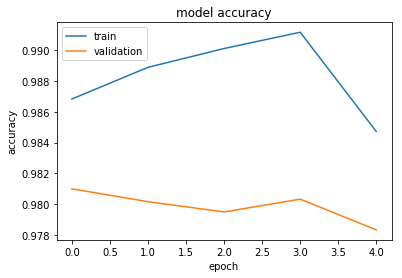

In [36]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

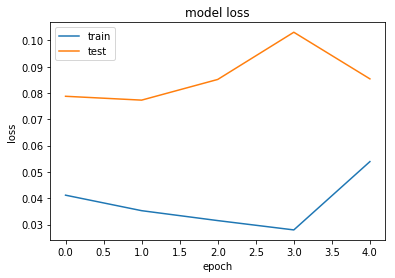

In [37]:

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()